* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора
import matplotlib
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'svg'

### 1. Чтение данных

In [3]:
df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('test.csv')


preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])


del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


0

#### 1.  EDA
* Исправления выбросов
* Заполнения NaN
* Генерации новых фич

In [4]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [5]:
X.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B


In [6]:
X.info()
# Healthcare_1 удаляем, LifeSquare - заплняем медианой

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
dtypes: 

In [7]:
X['Rooms'].value_counts()
# > 5 комнат = 5
# 0 комнат = 1

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [8]:
X[X['KitchenSquare'] > X['Square']]
# если площадь больше площади квартиры заменяем медианой

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B


In [9]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [10]:
X['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
48.0        2
99.0        2
39.0        2
117.0       1
29.0        1
31.0        1
38.0        1
44.0        1
36.0        1
26.0        1
45.0        1
47.0        1
Name: HouseFloor, dtype: int64

In [11]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [12]:
X.loc[X['Floor'] > X['HouseFloor'], ['Floor', 'HouseFloor']]
# Этаж выше этажности дома заменяем на этажность дома // 2

,Floor,HouseFloor
Id,,
11993,14,0.0
10953,5,4.0
2119,6,5.0
11935,15,1.0
6641,2,0.0
...,...,...
2237,11,9.0
16159,10,1.0
4145,26,24.0


In [13]:
X['HouseYear'].sort_values().unique()
# < 2020

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [14]:
X.DistrictId.nunique()

205

In [15]:
X['Ecology_1'].unique()

array([8.90397190e-02, 6.99893000e-05, 4.96372570e-02, 4.37885240e-01,
       1.23388860e-02, 3.09479124e-01, 4.60556389e-01, 7.57787550e-02,
       7.12231700e-03, 1.18537385e-01, 0.00000000e+00, 9.07991030e-02,
       1.33215333e-01, 7.21575810e-02, 3.71778180e-02, 5.18154350e-02,
       6.97533610e-02, 9.91363000e-04, 3.19809354e-01, 2.11401214e-01,
       4.11246340e-02, 6.07615200e-03, 2.07413260e-02, 3.46560820e-02,
       1.69676000e-04, 7.65851500e-03, 3.00322518e-01, 1.76470530e-02,
       3.61222920e-02, 2.65088676e-01, 1.50168920e-02, 3.34937080e-02,
       2.25824954e-01, 6.07530490e-02, 1.94489265e-01, 1.44231140e-02,
       1.40729610e-02, 1.95781053e-01, 2.18439740e-01, 2.82797669e-01,
       1.75054867e-01, 1.50817539e-01, 5.76745100e-03, 1.27375905e-01,
       2.43204519e-01, 3.71148999e-01, 1.51346216e-01, 1.69091090e-01,
       1.36244425e-01, 4.11163540e-02, 2.10473241e-01, 3.13924552e-01,
       3.06977489e-01, 3.41071945e-01, 4.28825818e-01, 1.49666373e-01,
      

In [16]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms

        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 5, 'Rooms'] = 5
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = X.loc[X['KitchenSquare'] < 3, 'Square'] / 1 # Кухня в среднем занимает 11% от квартиры
        X.loc[X['KitchenSquare'] > X['Square'], 'KitchenSquare'] = self.medians['KitchenSquare'] # Заменяем медианой значения больше площади квартиры
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'] // 2
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns: 
            X.drop('Healthcare_1', axis=1, inplace=True) # Удаляем 
            
        # LifeSquare
        X['LifeSquare'].fillna(0, inplace=True)
        
        X.loc[X['LifeSquare'] == 0, 'LifeSquare'] = self.medians['LifeSquare']
       
        
        return X

In [17]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [18]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        ## square
        if y is not None:
            df['Price'] = y.values
            df = self.square_to_cat(df)
            self.med_price_by_square = df.groupby(['square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
        ## ecology_1, year
        if y is not None:
            df['Price'] = y.values
            df = self.ecology_1_to_cat(df)
            self.med_price_by_ecology_year = df.groupby(['year_cat', 'ecology_1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcology1Year'})

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X) 
        X = self.square_to_cat(X)
        X = self.ecology_1_to_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['square_cat'], how='left')
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_ecology_year, on=['year_cat', 'ecology_1_cat'], how='left')
        
        
        return X
    
    @staticmethod
    def ecology_1_to_cat(X):
        
        X['ecology_1_cat'] = np.nan
        
        X.loc[X['Ecology_1'] < 1, 'ecology_1_cat'] = 1  
        X.loc[(X['Ecology_1'] >= 1) & (X['Ecology_1'] <= 2), 'ecology_1_cat'] = 2
        X.loc[(X['Ecology_1'] > 2) & (X['Ecology_1'] <= 3), 'ecology_1_cat'] = 3
        X.loc[(X['Ecology_1'] > 3) & (X['Ecology_1'] <= 4), 'ecology_1_cat'] = 4
        X.loc[(X['Ecology_1'] > 5) & (X['Ecology_1'] <= 6), 'ecology_1_cat'] = 5
        X.loc[X['Ecology_1'] > 6, 'ecology_1_cat'] = 6
            
        return X
    
    @staticmethod
    def square_to_cat(X):
        
        X['square_cat'] = np.nan
        
        X.loc[X['Square'] < 20, 'square_cat'] = 1  
        X.loc[(X['Square'] >= 20) & (X['Floor'] <= 50), 'square_cat'] = 2
        X.loc[(X['Square'] > 50) & (X['Floor'] <= 70), 'square_cat'] = 3
        X.loc[(X['Square'] > 70) & (X['Floor'] <= 100), 'square_cat'] = 4
        X.loc[X['Square'] > 100, 'square_cat'] = 5
            
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X

In [19]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [20]:
# Удаляю, просто чтобы было быстрее строить модель. Возможно, вам стоит что-то сделать с не количественными признаками
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1', 
                   'HouseYear_outlier', 'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedPriceBySquare', 'MedPriceByEcology1Year']

X = X[remain_features]
X_final = X_final[remain_features]

In [21]:
model = LGBMRegressor(max_depth=10,
                             min_samples_leaf=7,
                             n_estimators=300,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.736 +- 0.020


In [22]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=7,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

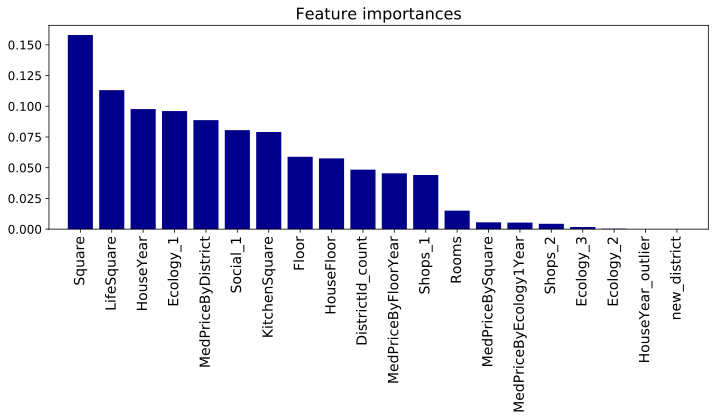

In [23]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (10, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [24]:
y_pred_final = model.predict(X_final)

# preds_final = pd.DataFrame()
# preds_final['Id'] = X_final.index
preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,157724.753447
1,15856,244365.030430
2,5480,177569.928768
3,15664,321987.512089
4,14275,146080.002666
